In [0]:
import pandas as pd

import torch
from torch import nn, optim
from torch.functional import F

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

import math
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')

# Data loading

Данные - https://www.kaggle.com/blastchar/telco-customer-churn

предсказать вероятность оттока пользователей сервиса

In [35]:
df_churn = pd.read_csv("http://nagornyy.me/datasets/telco-customer-churn.zip")
df_churn.shape

(7043, 21)

In [36]:
df_churn.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Analysis

In [99]:
df_churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

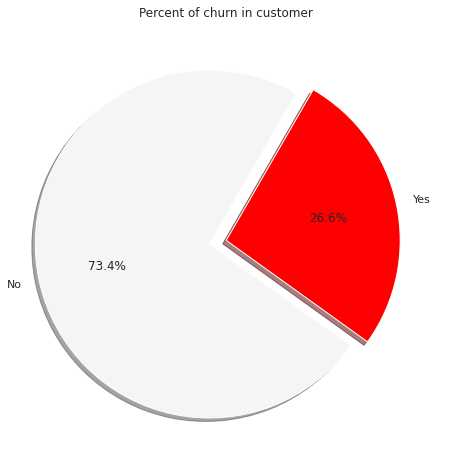

In [96]:
from pylab import rcParams

labels =df_churn.Churn.value_counts(sort = True).index
sizes = df_churn.Churn.value_counts(sort = True)

colors = ["whitesmoke","red"]
explode = (0.1,0)  # explode 1st slice
 
rcParams['figure.figsize'] = 8,8
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=60,)

plt.title('Percent of churn in customer')
plt.show()

In [0]:
columns_idx = np.s_[0:] 
first_record_idx = np.s_[0] 

string_fields = [type(fld) is str for fld in df_churn.iloc[first_record_idx, columns_idx]]
all_features = [x for x in df_churn.columns if x != 'Churn']
categorical_columns = list(np.array(df_churn.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

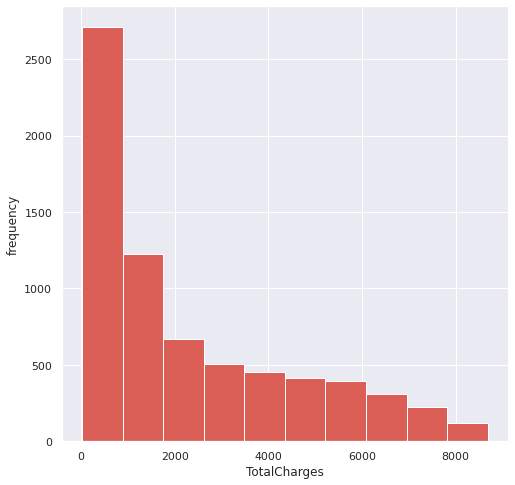

In [106]:
plt.figure()
df_churn.TotalCharges.hist();
plt.xlabel('TotalCharges');
plt.ylabel('frequency');

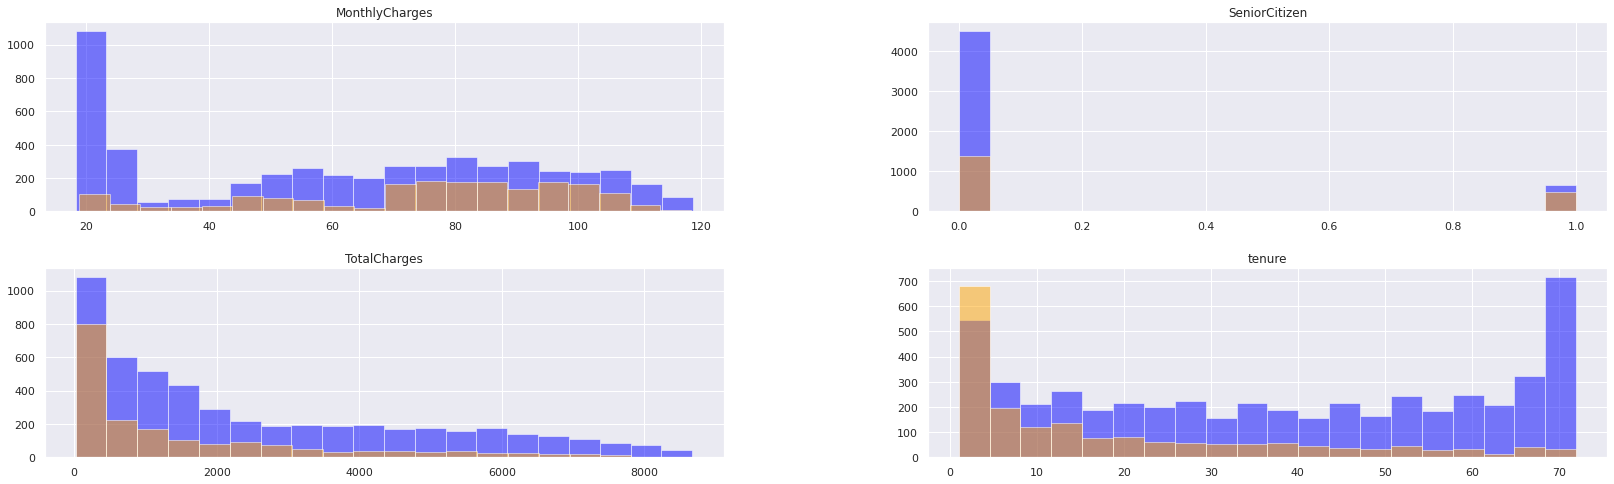

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(28, 8))
df_churn[df_churn.Churn == 'No'][continuous_features].hist(bins=20, color="blue", alpha=0.5, ax=ax);
df_churn[df_churn.Churn == 'Yes'][continuous_features].hist(bins=20, color="orange", alpha=0.5, ax=ax);

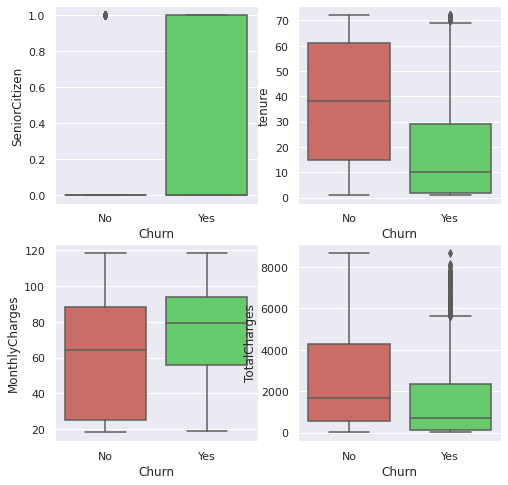

In [86]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(continuous_features)):
    sns.boxplot(x = 'Churn', y = continuous_features[i], data=df_churn, ax=ax[i])

In [0]:
df_churn["TotalCharges"] = pd.to_numeric(df_churn.TotalCharges, errors="coerce")
df_churn.dropna(inplace=True)

In [0]:
df_churn['Churn']=df_churn['Churn'].replace({"Yes":1,"No":0})

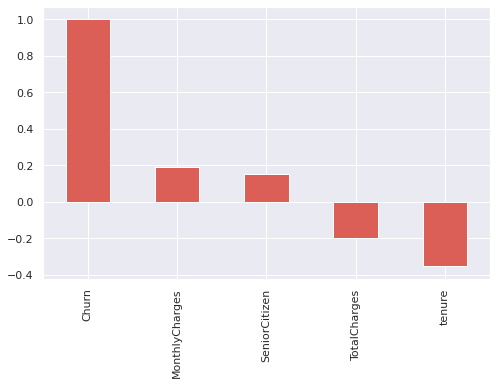

In [134]:
plt.figure(figsize=(8,5))
df_churn.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

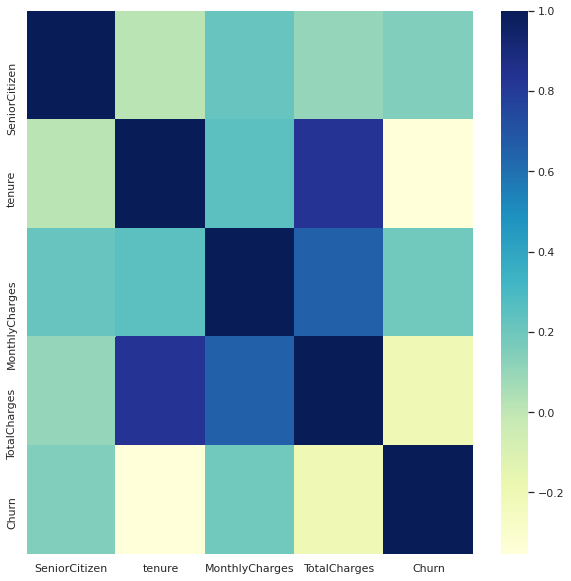

In [138]:
corr=df_churn.corr().iloc[:,:] 
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=False,cmap="YlGnBu")

In [0]:
X = df_churn[["tenure", "MonthlyCharges", "TotalCharges"]] # три вещественных признака
y = df_churn["Churn"]  # таргет

In [0]:
y_tensor = torch.from_numpy(y.values.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(X.values).float()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=42, shuffle=False)

## Model Building

In [125]:
# classical models

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
predicted = logreg.predict(X_test)
roc_auc_score(y_test, predicted)

0.7316561844863732

In [115]:
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train) 
predicted = tree.predict(X_test)
roc_auc_score(y_test, predicted)

0.6535687941610373

In [116]:
entropy = DecisionTreeClassifier(criterion='entropy',class_weight='balanced') 
entropy.fit(X_train, y_train) 
predicted = entropy.predict(X_test)
roc_auc_score(y_test, predicted)

0.6607704402515723

In [118]:
from sklearn.ensemble import RandomForestClassifier
r = RandomForestClassifier(n_estimators=100,n_jobs=-1,oob_score=True,
                           class_weight='balanced',max_depth=14,random_state = 20,max_leaf_nodes = 29,min_samples_leaf = 6)
r.fit(X_train, y_train) 
predicted = r.predict(X_test)
roc_auc_score(y_test, predicted)

0.7439145119962731

In [119]:
from xgboost import XGBClassifier
xg = XGBClassifier(n_jobs= -1,n_estimators= 500,booster='gblinear',max_delta_step= 2)
xg.fit(X_train, y_train) 
predicted = xg.predict(X_test)
roc_auc_score(y_test, predicted)

0.6751349095426663

In [140]:
# Neural Network
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    def forward(self, X):
        predictions = self.linear(X)
        return torch.sigmoid(predictions)


model = LogisticRegressionTorch(X_train.shape[1], y_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    #print('эпоха', epoch)
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    #print('лосс:', float(loss))
    #print('качество', roc_auc_score(y_test, model(X_test).detach().numpy()))
    # вычисляем градиенты
    loss.backward()
    # обновляем параметры
    optimizer.step()

predictions = model(X_test)
print('roc_auc', roc_auc_score(y_test, predictions.detach().numpy()))

roc_auc 0.8138094637264798
